## Robustness of modality estimation

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

import modish

%load_ext autoreload
%autoreload 2

%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
size = 100
psi0 = pd.Series(np.random.uniform(0, 0.1, size=size), name='~0')
psi1 = pd.Series(np.random.uniform(0.9, 1, size=size), name='~1')
middle = pd.Series(np.random.uniform(0.45, 0.55, size=size),
                   name='middle')
bimodal = pd.Series(np.concatenate([
    np.random.uniform(0, 0.05, size=size / 2),
    np.random.uniform(0.95, 1, size=size / 2)]), name='bimodal')
ideal_modalities = pd.concat([psi0, psi1, middle, bimodal], axis=1)
ideal_modalities.head()

,~0,~1,middle,bimodal
0,0.076641,0.940103,0.478943,0.003379
1,0.098096,0.977753,0.502508,0.045239
2,0.097506,0.941355,0.457348,0.021923
3,0.036056,0.935451,0.518119,0.018230
4,0.006027,0.971290,0.452635,0.001547


Reshape data into a "tidy/tall" dataframe for easier plotting with seaborn

In [140]:
ideal_modalities_tidy = ideal_modalities.unstack()
ideal_modalities_tidy = ideal_modalities_tidy.reset_index()
ideal_modalities_tidy = ideal_modalities_tidy.rename(columns={'level_0':'modality', 'level_1': 'sample_id', 0:'$\Psi$'})
ideal_modalities_tidy.modality = pd.Categorical(ideal_modalities_tidy.modality, 
                                                categories=['~0', 'middle', '~1', 'bimodal'],
                                                ordered=True)
ideal_modalities_tidy.head()

,modality,sample_id,$\Psi$
0,~0,0,0.076641
1,~0,1,0.098096
2,~0,2,0.097506
3,~0,3,0.036056
4,~0,4,0.006027


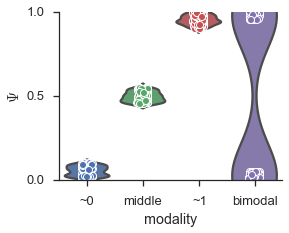

In [141]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.violinplot(x='modality', y="$\Psi$",
               data=ideal_modalities_tidy, scale='width', inner=None)
sns.stripplot(x='modality', y="$\Psi$",
               data=ideal_modalities_tidy, jitter=True)
sns.despine()
ax.set(ylim=(0, 1), yticks=[0, 0.5, 1]);

### Use `modish` to estimate modalities on these ideal modalities, iteratively adding uniformly random noise

In [164]:
%%time

CHANGING_PARAMETERS = np.arange(2, 20)
TWO_PARAMETER_MODELS = {'bimodal': {'alphas': 1./CHANGING_PARAMETERS,
                                    'betas': 1./CHANGING_PARAMETERS},
                        'middle': {'alphas': CHANGING_PARAMETERS,
                                   'betas': CHANGING_PARAMETERS}}
ONE_PARAMETER_MODELS = {'~0': {'alphas': 1,
                               'betas': CHANGING_PARAMETERS},
                        '~1': {'alphas': CHANGING_PARAMETERS,
                               'betas': 1}}

estimator = modish.ModalityEstimator(one_parameter_models=ONE_PARAMETER_MODELS,
                 two_parameter_models=TWO_PARAMETER_MODELS)


CPU times: user 141 ms, sys: 7 ms, total: 148 ms
Wall time: 138 ms


In [165]:
folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities_supplementary'

In [166]:
mkdir $folder

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities_supplementary': File exists


In [174]:
noisy_modalities.head()

,~0,~1,middle,bimodal
0,0.963526,0.697919,0.312174,0.266734
1,0.345878,0.271588,0.423982,0.692957
2,0.521919,0.436622,0.135609,0.394169
3,0.783640,0.833274,0.652282,0.501705
4,0.741524,0.764377,0.978307,0.025642


In [176]:
np.random.permutation(noisy_modalities.index.tolist())

array([ 2, 98, 57, 11, 54, 76,  5, 92,  1,  9, 49, 38, 95, 72, 82, 86, 36,
        7, 13, 23, 97, 35, 75, 67, 26, 31, 78, 85, 27, 40, 22, 91, 45, 20,
       68, 83, 77, 24, 34, 69,  4, 60, 42, 90,  8, 18,  0, 53, 96, 62, 51,
       94, 59, 19, 39, 33, 46, 88, 47, 21, 43, 73, 74, 28, 66, 65, 80, 63,
        6, 16, 50, 41, 15, 93, 30,  3, 70, 58, 84, 52, 32, 81, 10, 25, 79,
       89, 48, 29, 12, 71, 61, 87, 37, 14, 44, 56, 17, 99, 55, 64])

Randomize the row order of ideal modalities because bimodal has all the excluded samples from 1-50

In [180]:
ideal_modalities = ideal_modalities.reindex(index=np.random.permutation(ideal_modalities.index.tolist()))
ideal_modalities.index = np.arange(ideal_modalities.shape[0])
ideal_modalities.head()

,~0,~1,middle,bimodal
0,0.034059,0.938755,0.541950,0.977378
1,0.073831,0.925136,0.472527,0.995043
2,0.038633,0.914007,0.460202,0.047621
3,0.029780,0.915061,0.455903,0.000959
4,0.074241,0.986893,0.472518,0.959608


(2004, 5)
(10020, 5)
CPU times: user 1min 53s, sys: 698 ms, total: 1min 54s
Wall time: 1min 55s


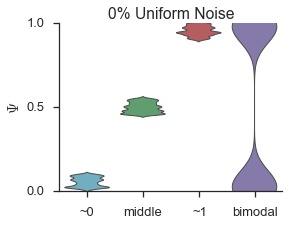

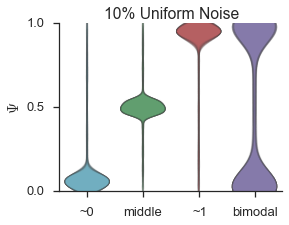

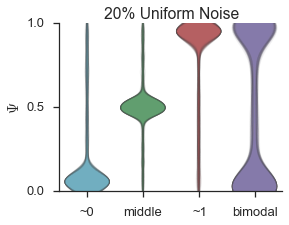

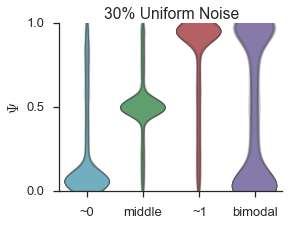

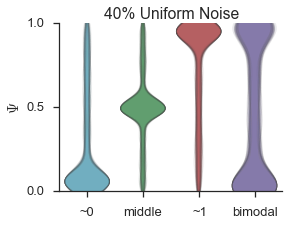

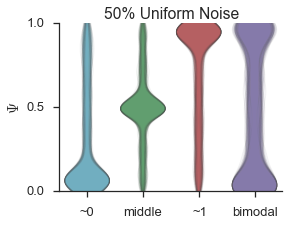

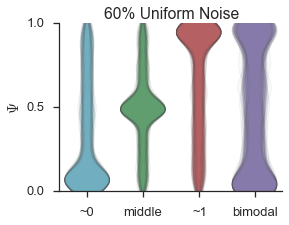

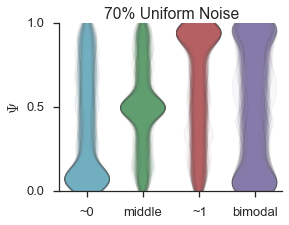

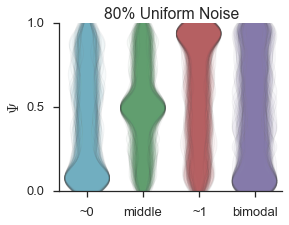

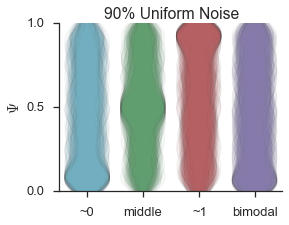

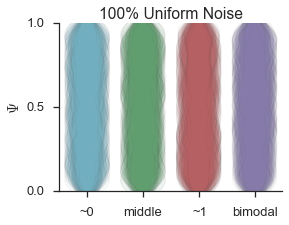

In [202]:
%%time
noise_percentages = np.arange(0, 101, step=10)
iter_per_noise = 50

log2bf_dfs = []
modalities_dfs = []

for noise_percentage in noise_percentages:
    fig, ax = plt.subplots(figsize=(4, 3))
    for i in range(iter_per_noise):
        if i > 0 and noise_percentage == 0:
            continue
        noisy_modalities = ideal_modalities.copy()
        shape = (noise_percentage, noisy_modalities.shape[1])
        size = np.product(shape)
        noisy_modalities.iloc[:noise_percentage] = np.random.uniform(low=0., high=1., size=size).reshape(shape)
        sns.violinplot(noisy_modalities, bw=0.2, inner=None, order=MODALITY_ORDER[:-1],
              palette=palette, linewidth=1, scale='width')

    
        log2bf = estimator.fit_transform(noisy_modalities)
        modalities = estimator.assign_modalities(log2bf)
        
        log2bf_df = log2bf.unstack().reset_index()
        log2bf_df = log2bf_df.rename(columns={'level_0': 'true_modality', 
                                              'level_1': 'guessed_modality', 
                                              0: 'log2_bayes_factor'})
        log2bf_df['noise_percentage'] = noise_percentage
        log2bf_df['noise_iter'] = i
        log2bf_dfs.append(log2bf_df)
        
        modalities_df = modalities.reset_index()
        modalities_df = modalities_df.rename(columns={'index': 'true_modality', 0: 'guessed_modality'})
        modalities_df['correct_modality'] = modalities_df.true_modality == modalities_df.guessed_modality
        modalities_df['noise_percentage'] = noise_percentage
        modalities_df['noise_iter'] = i
        modalities_dfs.append(modalities_df)
    if noise_percentage > 0:
        for c in ax.collections:
            c.set_alpha(0.05)
    ax.set(ylim=(0, 1), title='{}% Uniform Noise'.format(noise_percentage),
          yticks=(0, 0.5, 1), ylabel='$\Psi$')
    sns.despine()
    fig.savefig('{}/modality_estimation2_noise_percentage_{}.pdf'.format(folder, noise_percentage))

        
modalities = pd.concat(modalities_dfs, ignore_index=True)
log2bf = pd.concat(log2bf_dfs, ignore_index=True)
print modalities.shape
print log2bf.shape
modalities.head()

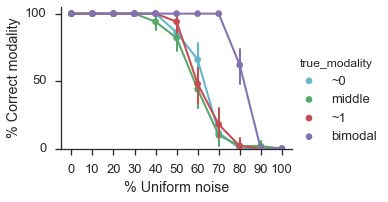

In [205]:
from modish.visualize import MODALITY_ORDER, MODALITY_COLORS
import matplotlib as mpl

order = MODALITY_ORDER[:-1]
palette = [mpl.colors.rgb2hex(MODALITY_COLORS[m]) for m in order]

g = sns.factorplot(data=modalities, y='correct_modality', x='noise_percentage', hue='true_modality', size=3, aspect=1.5,
                   palette=palette, hue_order=order, scale=0.5)
g.set(ylim=(0, 1.05), yticks=(0, 0.5, 1), yticklabels=(0, 50, 100), ylabel="% Correct modality",
     xlabel='% Uniform noise')
g.savefig('{}/modish_estimation_percent_correct_modality.pdf'.format(folder))

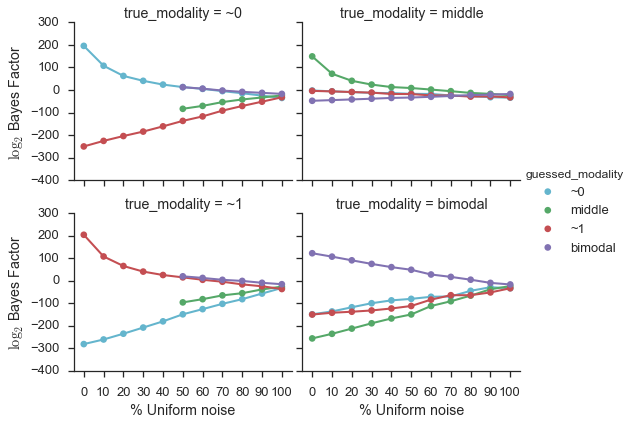

In [204]:
order = MODALITY_ORDER[:-1]
palette = [mpl.colors.rgb2hex(MODALITY_COLORS[m]) for m in order]
g = sns.factorplot(y='log2_bayes_factor', x='noise_percentage', col='true_modality', hue='guessed_modality',
                   data=log2bf, hue_order=order, palette=palette, col_order=order, col_wrap=2, size=3, aspect=1.25,
                  scale=0.5)
for ax in g.axes.flat:
    if ax.is_first_col():
        ax.set_ylabel('$\log_2$ Bayes Factor')
    if ax.is_last_row():
        ax.set_xlabel('% Uniform noise')
g.savefig('{}/modish_estimation_log2_bayes_factors.pdf'.format(folder))